In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import numpy as np


In [20]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'


In [21]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:

NUM_CLASSES = 10
BATCH_SIZE = 8
LEARNING_RATE = 1e-4

try:
    set_global_policy('float32')  # Use float32 to avoid CPU fallback issues
    print("✅ Mixed Precision disabled — using float32 for stability.")
except Exception as e:
    print(f"⚠️ Precision setup failed: {e}")


✅ Mixed Precision disabled — using float32 for stability.


In [23]:
def build_model(num_classes):
    inputs = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False  # Freeze base for transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)
    return model

In [24]:
model = build_model(NUM_CLASSES)
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Path to your dataset
DATASET_PATH = "./dataset_mri"

# Load training and validation datasets
train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"  # Ensures one-hot encoding
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
    layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
])


train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)

val_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)
     

Found 24877 files belonging to 10 classes.
Using 19902 files for training.
Found 24877 files belonging to 10 classes.
Using 4975 files for validation.


In [26]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:


# Load raw training dataset (no shuffle, no map, no prefetch)
raw_train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Extract labels batch-by-batch (memory-safe)
class_indices = []
for _, label_batch in raw_train_ds:
    class_indices.extend(tf.argmax(label_batch, axis=1).numpy())

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_indices),
    y=class_indices
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Found 24877 files belonging to 10 classes.
Using 19902 files for training.
Class weights: {0: 0.5590449438202247, 1: 0.5543732590529248, 2: 1.1470893371757924, 3: 0.6009057971014493, 4: 0.9504297994269341, 5: 0.704495575221239, 6: 2.6118110236220473, 7: 1.605, 8: 6.123692307692307, 9: 4.3359477124183}


2025-10-02 12:32:06.782858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:

# Define early stopping
early_exit = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
# Train the model
EPOCHS = 50  # Set high, early stopping will cut it short if needed

try:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weights_dict,
        callbacks=[early_exit, lr_scheduler]
    )
except Exception as e:
    print(f"⚠️ Training crashed: {e}")



Epoch 1/50


I0000 00:00:1759408333.558266    2053 service.cc:145] XLA service 0x7c6f58009cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759408333.558348    2053 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-10-02 12:32:13.657902: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1759408333.699820    2053 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-10-02 12:32:14.269183: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759408336.168987    2127 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5646', 116 bytes spill stores, 116 bytes spill loads



2487/2488 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5255 - loss: 1.3555

I0000 00:00:1759408410.335548    2371 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5646', 116 bytes spill stores, 116 bytes spill loads



2488/2488 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5255 - loss: 1.3553

I0000 00:00:1759408535.387425    2485 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1707', 116 bytes spill stores, 116 bytes spill loads



2488/2488 ━━━━━━━━━━━━━━━━━━━━ 211s 80ms/step - accuracy: 0.5255 - loss: 1.3552 - val_accuracy: 0.6876 - val_loss: 0.8156 - learning_rate: 1.0000e-04
Epoch 2/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 194s 78ms/step - accuracy: 0.7513 - loss: 0.6367 - val_accuracy: 0.7309 - val_loss: 0.7099 - learning_rate: 1.0000e-04
Epoch 3/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 172s 111ms/step - accuracy: 0.7960 - loss: 0.5254 - val_accuracy: 0.7463 - val_loss: 0.6665 - learning_rate: 1.0000e-04
Epoch 4/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.8164 - loss: 0.4632 - val_accuracy: 0.7604 - val_loss: 0.6454 - learning_rate: 1.0000e-04
Epoch 5/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 121s 48ms/step - accuracy: 0.8243 - loss: 0.4285 - val_accuracy: 0.7512 - val_loss: 0.6795 - learning_rate: 1.0000e-04
Epoch 6/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 119s 48ms/step - accuracy: 0.8371 - loss: 0.4054 - val_accuracy: 0.7588 - val_loss: 0.6353 - learning_rate: 1.0000e-04
Epoch 7/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 212

2025-10-02 12:58:19.468592: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 4817280 bytes after encountering the first element of size 4817280 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2487/2488 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8690 - loss: 0.3136
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 96s 38ms/step - accuracy: 0.8690 - loss: 0.3136 - val_accuracy: 0.7853 - val_loss: 0.5691 - learning_rate: 1.0000e-04
Epoch 13/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 152s 61ms/step - accuracy: 0.8721 - loss: 0.3019 - val_accuracy: 0.8034 - val_loss: 0.5378 - learning_rate: 5.0000e-05
Epoch 14/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 185s 74ms/step - accuracy: 0.8792 - loss: 0.2967 - val_accuracy: 0.8107 - val_loss: 0.5190 - learning_rate: 5.0000e-05
Epoch 15/50
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 126s 51ms/step - accuracy: 0.8749 - loss: 0.2923 - val_accuracy: 0.8008 - val_loss: 0.5419 - learning_rate: 5.0000e-05
Epoch 16/50
2487/2488 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8835 - loss: 0.2845
Epoch 16: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 112s 45ms/st

In [29]:
model.save("resnet50_cancer_model-MRI-version-1.keras")

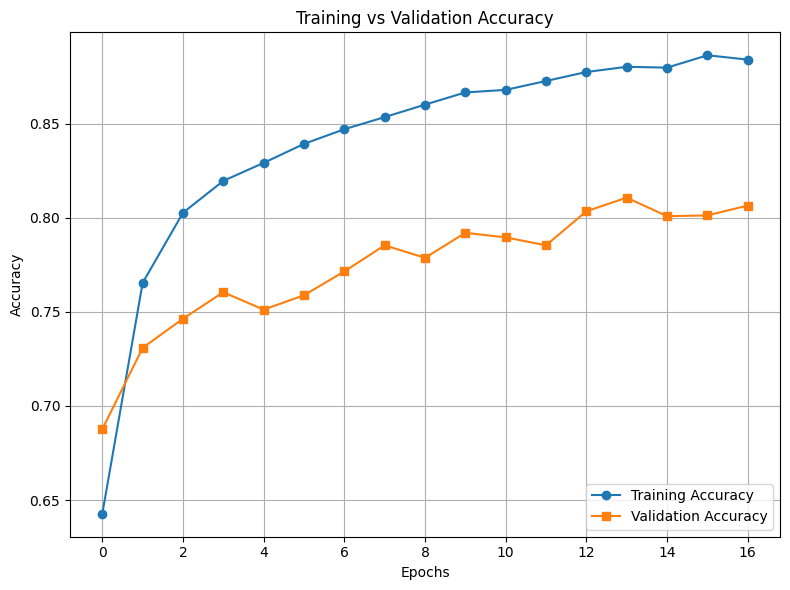

In [30]:
import matplotlib.pyplot as plt

# Extract accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(len(acc))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
